In [2]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 68.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Uninstalling cachetools-4.2.4:
      Successfully uninstalled cachetools-4.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.


In [3]:
import mlflow

# Set the MLflow tracking URI to a writable directory in Kaggle
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")


In [4]:
import os

model_save_path = "/kaggle/working/models/adversarial_model"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_rgb = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform_rgb)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_rgb)

cifar10_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True)
mnist_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)



100%|██████████| 170498071/170498071 [00:03<00:00, 46789122.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17532832.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 466577.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4363120.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2103636.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



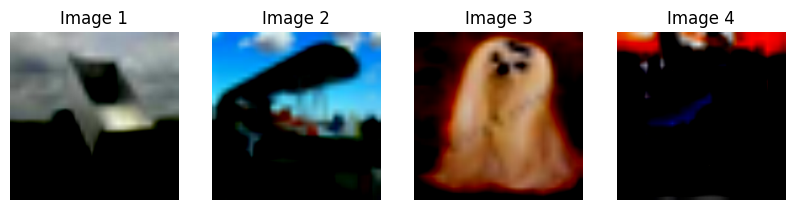

In [10]:
import matplotlib.pyplot as plt

images, labels = next(iter(cifar10_loader))

fig, axes = plt.subplots(1, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))  # permute the dimensions to correctly display the image
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.show()


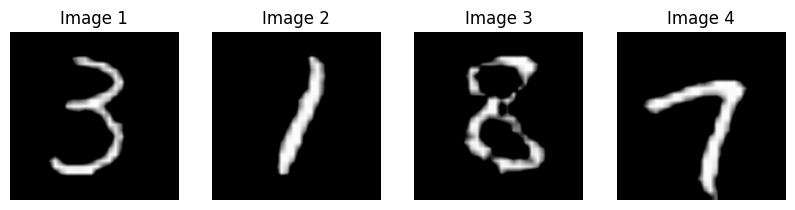

In [11]:
images, labels = next(iter(mnist_loader))

fig, axes = plt.subplots(1, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))  # permute the dimensions to correctly display the image
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.show()


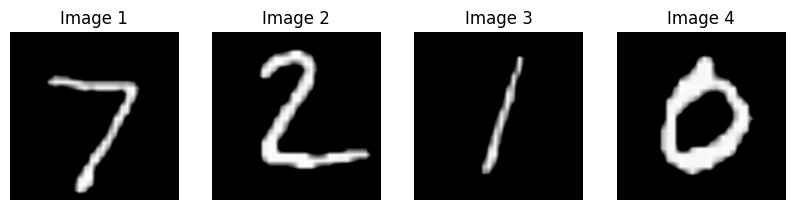

In [12]:
images, labels = next(iter(mnist_test_loader))

fig, axes = plt.subplots(1, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))  # permute the dimensions to correctly display the image
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.show()


In [6]:
# Initialize MLflow
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
mlflow.set_experiment("Adversarial Training Experiment")

# Load pre-trained Vision Transformer
model = vit_b_16(pretrained=True)
model.heads = nn.Linear(model.heads.head.in_features, 10)  # Adjusting for CIFAR-10
model = model.to(device)

# Load pre-trained Vision Transformer for baseline
model1 = vit_b_16(pretrained=True)
model1.heads = nn.Linear(model1.heads.head.in_features, 10)  # Adjusting for CIFAR-10
model1 = model1.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epsilon = 0.1



2024/05/21 03:48:12 INFO mlflow.tracking.fluent: Experiment with name 'Adversarial Training Experiment' does not exist. Creating a new experiment.
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 156MB/s]  


In [7]:
# FGSM attack implementation
def fgsm_attack_batched(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_images = images + epsilon * sign_data_grad
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images

# Generate adversarial examples
def generate_adversarial_examples_batched(model, loader, epsilon, max_examples=1000, batch_size=32):
    model.eval()
    adv_examples = []
    total_examples = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        num_batches = (len(images) + batch_size - 1) // batch_size
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            perturbed_batch = fgsm_attack_batched(model, images[start_idx:end_idx], 
                                                  labels[start_idx:end_idx], epsilon)
            adv_examples.append((perturbed_batch, labels[start_idx:end_idx]))
            total_examples += end_idx - start_idx
            if total_examples >= max_examples:
                return adv_examples
    return adv_examples

max_examples = 1000
adv_examples = generate_adversarial_examples_batched(model, mnist_test_loader, epsilon, max_examples)



In [8]:
# FGSM Attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

# Training function
def train(model, loader, criterion, optimizer, epsilon):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True  # Enable gradient tracking for images

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # FGSM adversarial attack
        data_grad = images.grad.data
        perturbed_data = fgsm_attack(images, epsilon, data_grad)
        
        # Recompute outputs on perturbed data
        optimizer.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    return running_loss / len(loader)

# Training Function for baseline model
def train_b(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Fine-tuning function
def fine_tune(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Evaluate model on adversarial MNIST examples
def evaluate_on_adversarial(model, adv_examples):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in adv_examples:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



In [9]:
# Logging experiments with MLflow
with mlflow.start_run() as run:
    # Log hyperparameters
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("epsilon", epsilon)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 1)

    # Train on CIFAR-10 without adversarial examples
    for epoch in range(1):
        avg_loss = train_b(model1, cifar10_loader, criterion, optimizer)
        print(f"Baseline Training Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")
        mlflow.log_metric("baseline_training_loss", avg_loss, step=epoch)

    # Fine-tune on MNIST without adversarial examples
    for epoch in range(1):
        avg_loss = fine_tune(model1, mnist_loader, criterion, optimizer)
        print(f"Baseline Fine-tuning Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")
        mlflow.log_metric("baseline_fine_tuning_loss", avg_loss, step=epoch)

    # Evaluate baseline model on MNIST test set
    baseline_accuracy = evaluate(model1, mnist_test_loader)
    print(f"Baseline Accuracy on MNIST test set: {baseline_accuracy*100:.2f}%")
    mlflow.log_metric("baseline_accuracy", baseline_accuracy)

    for epoch in range(1):
        avg_loss = train(model, cifar10_loader, criterion, optimizer, epsilon)
        print(f"Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")
        mlflow.log_metric("adversarial_training_loss", avg_loss, step=epoch)

    # Fine-tune on MNIST
    for epoch in range(1):
        avg_loss = fine_tune(model, mnist_loader, criterion, optimizer)
        print(f"Fine-tuning Epoch [{epoch+1}/5], Loss: {avg_loss:.4f}")
        mlflow.log_metric("adversarial_fine_tuning_loss", avg_loss, step=epoch)

    # Evaluate on MNIST
    accuracy = evaluate(model, mnist_test_loader)
    print(f'Accuracy on MNIST test set: {accuracy*100:.2f}%')
    mlflow.log_metric("accuracy", accuracy)

    # Evaluate baseline model on adversarial MNIST examples
    baseline_adv_accuracy = evaluate_on_adversarial(model1, adv_examples)
    print(f"Baseline Model Accuracy on Adversarial MNIST test set: {baseline_adv_accuracy*100:.2f}%")
    mlflow.log_metric("baseline_adv_accuracy", baseline_adv_accuracy)

    # Adversarially trained model performance on adversarial MNIST examples
    adv_adv_accuracy = evaluate_on_adversarial(model, adv_examples)
    print(f"Adversarial Model Accuracy on Adversarial MNIST test set: {adv_adv_accuracy*100:.2f}%")
    mlflow.log_metric("adversarial_accuracy", adv_adv_accuracy)

#     # Log the model
#     mlflow.pytorch.log_model(model, "model")
    # Logging model1 (baseline model)
    mlflow.pytorch.log_model(model1, "baseline_model")
    # Logging model (adversarial model)
    mlflow.pytorch.log_model(model, "adversarial_model")


Baseline Training Epoch [1/5], Loss: 2.4371
Baseline Fine-tuning Epoch [1/5], Loss: 2.4023
Baseline Accuracy on MNIST test set: 9.98%
Epoch [1/5], Loss: 2.0460
Fine-tuning Epoch [1/5], Loss: 1.2558
Accuracy on MNIST test set: 73.52%
Baseline Model Accuracy on Adversarial MNIST test set: 5.96%
Adversarial Model Accuracy on Adversarial MNIST test set: 11.52%


In [20]:
# # Logging model1 (baseline model)
# with mlflow.start_run() as run_baseline:
#     mlflow.pytorch.log_model(model1, "baseline_model")

# # Logging model (adversarial model)
# with mlflow.start_run() as run_adversarial:
#     mlflow.pytorch.log_model(model, "adversarial_model")

In [21]:
# Get the run ID
run_id = run.info.run_id
print("Run ID:", run_id)

Run ID: 7b45dbb49e024462ab8d654f167293e2


In [22]:
import shutil
shutil.make_archive('/kaggle/working/mlruns', 'zip', '/kaggle/working/mlruns')


'/kaggle/working/ml2.zip'

In [19]:
import mlflow

print(mlflow.__version__)

2.13.0
